# Квантовая нейронная сеть

## Обработка данных

Для начала нужно перевести наши данные в квантовые состояния. А для этого нужно привести данные в нужную размерность, буду использовать датасет https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay?resource=download.

Нашей меткой будет являтся Delay, который показывает будет ли задержан авиарейс. Считаем датасет.

In [6]:
import csv

dataset = []

with open("Airlines.csv", "r+", encoding="UTF-8") as f:
    reader = csv.reader(f)
    for i in reader:
        dataset.append(i[1:])
dataset, headers = dataset[1:], dataset[0]
headers, dataset[:5]

(['Airline',
  'Flight',
  'AirportFrom',
  'AirportTo',
  'DayOfWeek',
  'Time',
  'Length',
  'Delay'],
 [['CO', '269', 'SFO', 'IAH', '3', '15', '205', '1'],
  ['US', '1558', 'PHX', 'CLT', '3', '15', '222', '1'],
  ['AA', '2400', 'LAX', 'DFW', '3', '20', '165', '1'],
  ['AA', '2466', 'SFO', 'DFW', '3', '20', '195', '1'],
  ['AS', '108', 'ANC', 'SEA', '3', '30', '202', '0']])

Теперь переведем все признаки в целочисленные данные и отделим метки.

In [15]:
labels = [int(i[7]) for i in dataset]
labels[:5]

[1, 1, 1, 1, 0]

In [ ]:
d0 = {i:j for j,i in enumerate(set([i[0] for i in dataset]))}
d2 = {i:j for j,i in enumerate(set([i[2] for i in dataset]))}
d3 = {i:j for j,i in enumerate(set([i[3] for i in dataset]))}

dataset = [ [d0[d[0]], int(d[1]), d2[d[2]], d3[d[3]], int(d[4]), int(d[5]), int(d[6])] for d in dataset]
dataset[:5]

[[17, 269, 64, 286, 3, 15, 205],
 [3, 1558, 209, 38, 3, 15, 222],
 [5, 2400, 190, 51, 3, 20, 165],
 [5, 2466, 64, 51, 3, 20, 195],
 [7, 108, 263, 119, 3, 30, 202]]

Так как в четырехчастичную систему кубитов можно представить имея 2^(n+1)-2 параметров, то нам нужны вектора с размерностью 30(2^(4+1) - 2 = 30). Использую метод обобщенной сериализации через библиотеку genser.

In [27]:
from genser import transform_to

ds30 = transform_to(dataset, 30)[0]

Теперь переведем все данные в квантовые состояния

In [43]:
from math import cos, sin, pi
from functools import reduce
from cmath import rect
from qiskit.quantum_info import Statevector


def powers(DS): 
    """
    Вычисляет мощность признака в датасете
    """
    tDS = [[d[p] for d in DS] for p,_ in enumerate(DS[0])]
    return [max(ti)+1 for ti in tDS]


def Z_to_Q(data):
    """
    трансформирует датасет в квантовые состояния
    """
    n = int(len(data[0])/2)
    P = powers(data)
    zdata = []
    for d in data:
        delta = [d[i]/(P[i]-1)*pi/2 for i in range(n)]
        gamma = [d[i+n]/P[i+n]*pi*2 for i in range(n)]
        zl = [reduce(lambda a, b: a*b, [cos(delta[j]) for j in range(n)])]
        for i in range(1,n):
            zl.append(sin(delta[i-1])*reduce(lambda a, b: a*b, [cos(delta[j]) for j in range(i,n)])*rect(1,gamma[i-1]))
        zl.append(sin(delta[n-1])*rect(1,gamma[n-1]))
        zl = [complex(round(i.real, 3), round(i.imag, 3)) for i in zl]
        zdata.append(Statevector(zl))
    return zdata

In [44]:
qds = Z_to_Q(ds30)
qds[0]

Statevector([ 0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,
             -0.-0.j,  0.+0.j, -0.+0.j, -0.-0.j,  0.+0.j,  1.+0.j,  0.-0.j,
              0.+0.j,  0.+0.j],
            dims=(2, 2, 2, 2))


Иожно так же представить эти состояние в виде сфер блоха.

In [ ]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(qds[0])

## Построение нейронной сети

Будем строить простейшую КНС(квантовую нейронную сеть), состоящую из одного нейрона.

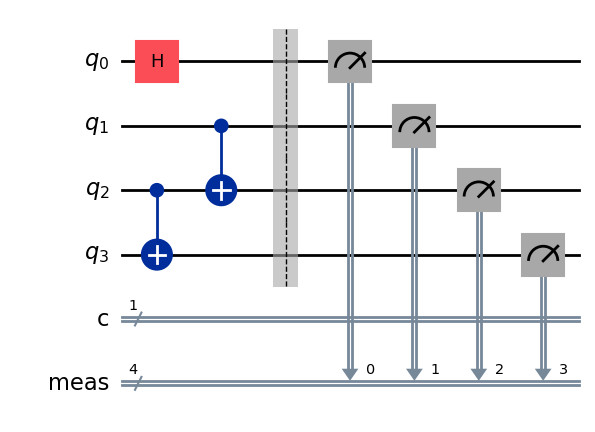

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import random_statevector

# Создание квантовой схемы с 3 кубитами и 2 классическими битами
qc = QuantumCircuit(4, 1)

# Строим нейрон
qc.h(0)
qc.cx(2, 3)
qc.cx(1, 2)

qc.measure_all()

# Визуализация схемы и гистограммы
qc.draw(output='mpl')
